In [1]:
import tensorflow as tf
import cleverhans
import numpy as np
import matplotlib.pyplot as plt
import keras
import foolbox
import pprint as pp
from PIL import Image
from keras.preprocessing import image as img
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

Using TensorFlow backend.


In [2]:
def load_image(extension: str):
  img_path = f'{extension}.jpg'
  image = img.load_img(img_path, target_size=(224, 224))
  plt.imshow(image)
  x = img.img_to_array(image)
  # x = np.expand_dims(x, axis=0)
  # x = preprocess_input(x)
  return x

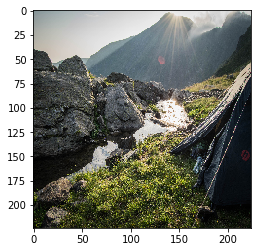

In [3]:
img2 = load_image('DSC_0897')
image, label = foolbox.utils.imagenet_example()
assert (img2.shape, img2.max(), type(img2))==(image.shape, image.max(), type(image))

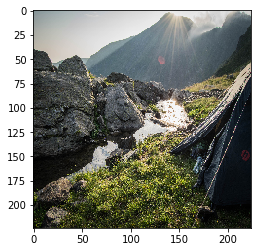

In [9]:
import keras
import numpy as np
from keras.applications.resnet50 import ResNet50

# instantiate model
keras.backend.set_learning_phase(0)
kmodel = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

image = load_image('DSC_0897')
to_classify = np.expand_dims(image, axis=0)
preds = kmodel.predict(to_classify)
label = np.argmax(preds)

# apply attack on source image
# ::-1 reverses the color channels, because Keras ResNet50 expects BGR instead of RGB
attack = foolbox.attacks.FGSM(fmodel, threshold=.5)
adversarial = attack(image[:, :, ::-1], label)
# if the attack fails, adversarial will be None and a warning will be printed

In [8]:
foolboxlbox.attacks.FGSM??

In [10]:
print('Predicted:', pp.pprint(decode_predictions(preds, top=20)[0]))

[('n03792972', 'mountain_tent', 0.68727505),
 ('n09399592', 'promontory', 0.07355865),
 ('n09468604', 'valley', 0.07171795),
 ('n04606251', 'wreck', 0.025214558),
 ('n09428293', 'seashore', 0.018810693),
 ('n01498041', 'stingray', 0.01020383),
 ('n04366367', 'suspension_bridge', 0.00910297),
 ('n02077923', 'sea_lion', 0.008893944),
 ('n09472597', 'volcano', 0.0077157747),
 ('n09421951', 'sandbar', 0.0056634448),
 ('n09193705', 'alp', 0.0052817613),
 ('n09256479', 'coral_reef', 0.005070684),
 ('n03042490', 'cliff_dwelling', 0.0048538684),
 ('n03788365', 'mosquito_net', 0.0040941825),
 ('n03450230', 'gown', 0.003981212),
 ('n09246464', 'cliff', 0.0034005924),
 ('n04507155', 'umbrella', 0.00259821),
 ('n09332890', 'lakeside', 0.0024168892),
 ('n02951358', 'canoe', 0.0020540736),
 ('n03160309', 'dam', 0.0020333952)]
Predicted: None


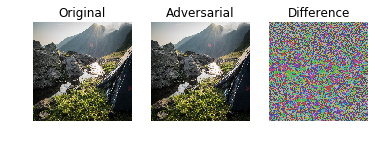

In [11]:
# if you use Jupyter notebooks
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure()

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(image / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

In [12]:
new_preds = kmodel.predict(np.expand_dims(adversarial, axis=0))
print('Predicted:', pp.pprint(decode_predictions(new_preds, top=20)[0]))

[('n04366367', 'suspension_bridge', 0.27551892),
 ('n03792972', 'mountain_tent', 0.26759607),
 ('n09472597', 'volcano', 0.25710547),
 ('n09468604', 'valley', 0.09390604),
 ('n09193705', 'alp', 0.03466299),
 ('n09246464', 'cliff', 0.030121733),
 ('n04346328', 'stupa', 0.008299703),
 ('n09399592', 'promontory', 0.0055106645),
 ('n09332890', 'lakeside', 0.0038562394),
 ('n03160309', 'dam', 0.0020365235),
 ('n02965783', 'car_mirror', 0.0017434784),
 ('n03788365', 'mosquito_net', 0.0015232521),
 ('n04275548', 'spider_web', 0.0014818179),
 ('n04613696', 'yurt', 0.0013899272),
 ('n03891251', 'park_bench', 0.0012903691),
 ('n02104365', 'schipperke', 0.001013231),
 ('n02667093', 'abaya', 0.0010092475),
 ('n09428293', 'seashore', 0.00091121765),
 ('n02951358', 'canoe', 0.0007187614),
 ('n03000134', 'chainlink_fence', 0.0005480902)]
Predicted: None


In [ ]:
plt.imshow(image / 255)

In [ ]:
assert False

In [ ]:
# !wget https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0897.jpg
# !wget https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0896.jpg

In [ ]:
img1 = load_image("DSC_0897")
# img1 = img1 / 255.0
preds = model.predict(x)
print('Predicted:', pp.pprint(decode_predictions(preds, top=20)[0]))

In [ ]:
w_model = KerasModelWrapper(model)
fgsm = FastGradientMethod(w_model, sess=sess)

# x = tf.convert_to_tensor(img1)
fgsm_params = {'eps': 0.001,
               'clip_min': 0.,
               'clip_max': 1.,
               'ord': 1}
img1 = load_image('DSC_0897')
img1 = img1 / 255.0
adv_x_np = fgsm.generate_np(img1, y=preds, **fgsm_params)
pic = adv_x_np * .01 + .99 * img1
# Consider the attack to be constant
adv_x2 = tf.stop_gradient(adv_x_np)
adv_x = tf.convert_to_tensor(adv_x_np)
# model = ResNet50(weights='imagenet')
preds_adv = model(adv_x2)
numeric_preds = preds_adv.eval(session=sess)
print('Predicted:', pp.pprint(decode_predictions(numeric_preds, top=20)[0]))


corrected_image2 = adv_x.eval(session=sess)[0,:,:,:]
plt.imshow(corrected_image2)

In [ ]:
pic = (pic + .5)
plt.imshow(pic[0,:,:,:])

In [ ]:
preds2 = model.predict(img2)
print('Predicted:', pp.pprint(decode_predictions(preds2, top=20)[0]))